In [1]:
import gensim
import json
import nltk
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB

# nltk.download("stopwords")
os.chdir("../../")
random.seed(42)

### Load and process data

In [2]:
train_df = pd.read_csv("data/processed/split/counsel-chat-best-answer-train.csv")
train_df = train_df[["questionText", "topic"]]
train_df["words"] = train_df["questionText"].apply(lambda x: list(filter(
    lambda word: word not in stopwords.words("english"), gensim.utils.simple_preprocess(x)
)))
train_df.head()

,questionText,topic,words
0,I have been diagnosed with general anxiety and...,depression,"[diagnosed, general, anxiety, depression, fami..."
1,There are many people willing to lovingly prov...,depression,"[many, people, willing, lovingly, provide, hom..."
2,My girlfriend just quit drinking and she becam...,depression,"[girlfriend, quit, drinking, became, really, d..."
3,I don't know how else to explain it. All I can...,depression,"[know, else, explain, say, feel, empty, feel, ..."
4,"I tried telling my husband I was depressed, an...",depression,"[tried, telling, husband, depressed, ignored, ..."


In [3]:
test_df = pd.read_csv("data/processed/split/counsel-chat-best-answer-test.csv")
test_df = test_df[["questionText", "topic"]]
test_df["words"] = test_df["questionText"].apply(lambda x: list(filter(
    lambda word: word not in stopwords.words("english"), gensim.utils.simple_preprocess(x)
)))
test_df.head()

,questionText,topic,words
0,I have so many issues to address. I have a his...,depression,"[many, issues, address, history, sexual, abuse..."
1,My mother is combative with me when I say I do...,depression,"[mother, combative, say, want, talk, depressio..."
2,A few years ago I was making love to my wife w...,depression,"[years, ago, making, love, wife, known, reason..."
3,I'm going through some things with my feelings...,depression,"[going, things, feelings, barely, sleep, nothi..."
4,I feel like I'm so alone. I treat people horri...,depression,"[feel, like, alone, treat, people, horribly, b..."


### Bag of words

In [4]:
term_freq = Counter([word for words in train_df.words for word in words])
unknown = "<UNK>"
vocabs = [unknown] + [word for word, count in sorted(
    term_freq.items(), key=lambda x: x[1], reverse=True
)[:31]]
vocabs[:10]

['<UNK>',
 'feel',
 'like',
 'know',
 'get',
 'want',
 'time',
 'years',
 'boyfriend',
 'really']

In [6]:
# with open("classifier/vocabs.txt", "w") as f:
#     for word in vocabs:
#         f.write(f"{word}\n")

In [7]:
def get_bow(ws):
    words = [word if word in vocabs else unknown for word in ws]
    return [words.count(v) for v in vocabs]
train_bow = np.array([
    get_bow(ws) for ws in train_df.words
])
train_bow.shape

(445, 32)

In [8]:
test_bow = np.array([
    get_bow(words) for words in test_df.words
])
test_bow.shape

(112, 32)

### Classes

In [9]:
topics = [topic for topic, count in Counter(train_df.topic).items() if count > 25]
topics

['depression',
 'anxiety',
 'parenting',
 'self-esteem',
 'intimacy',
 'family-conflict',
 'relationships']

### Naive bayes

In [10]:
metrics = {}
preds = {}
data = {}
for t in topics:
    train_topics = [1 if topic == t else 0 for topic in train_df.topic]
    train_samples = random.sample([i for i, topic in enumerate(train_topics) if topic == 0], train_topics.count(1) * 2)
    train_samples = sorted(train_samples + [i for i, topic in enumerate(train_topics) if topic == 1])
    train_bow_t = [bow for i, bow in enumerate(train_bow) if i in train_samples]
    train_topics_t = [topic for i, topic in enumerate(train_topics) if i in train_samples]
    data[t] = {"X": [bow.tolist() for bow in train_bow_t], "y": train_topics_t}
    gnb = GaussianNB()
    gnb.fit(train_bow_t, train_topics_t)
    test_topics = [1 if topic == t else 0 for topic in test_df.topic]
    test_preds = gnb.predict(test_bow)
    preds[t] = test_preds.copy()
    metrics[t] = {
        "accuracy": accuracy_score(test_topics, test_preds),
        "precision": precision_score(test_topics, test_preds),
        "recall": recall_score(test_topics, test_preds),
        "f1": f1_score(test_topics, test_preds)
    }

In [9]:
# with open("classifier/training_data.json", "w") as f:
#     json.dump(data, f)

In [10]:
metrics_df = pd.DataFrame.from_dict(metrics, orient="index")
metrics_df

,accuracy,precision,recall,f1
depression,0.491071,0.235294,0.761905,0.359551
anxiety,0.375000,0.121622,0.642857,0.204545
parenting,0.437500,0.090909,0.666667,0.160000
self-esteem,0.250000,0.011905,0.500000,0.023256
intimacy,0.392857,0.100000,0.583333,0.170732
family-conflict,0.339286,0.075949,0.857143,0.139535
relationships,0.687500,0.179487,0.700000,0.285714


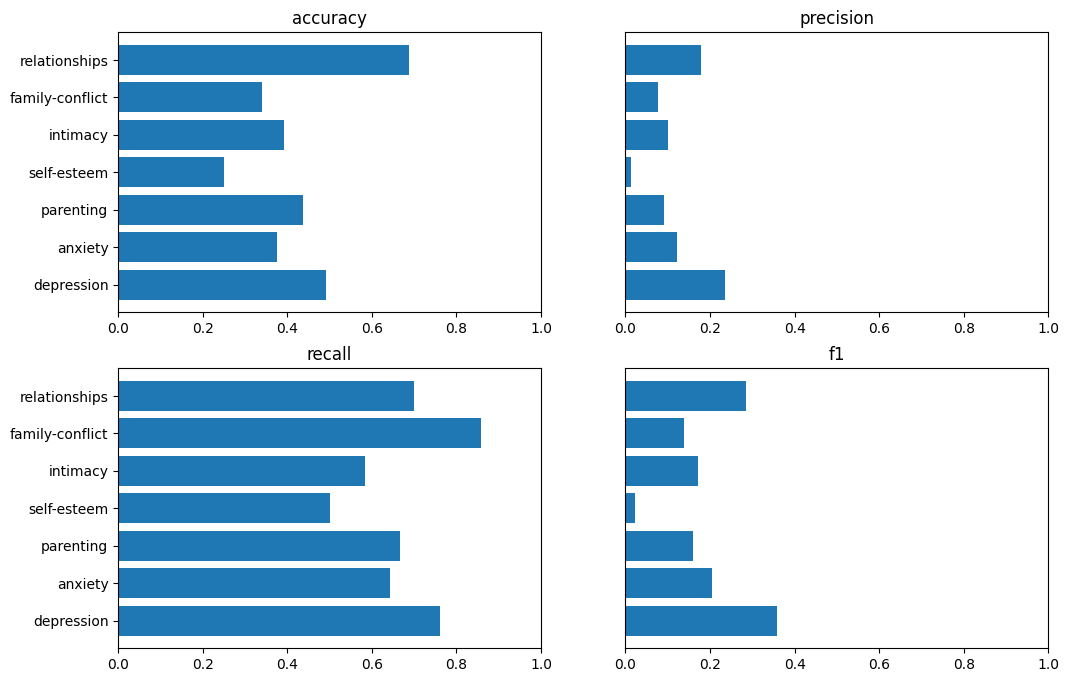

In [11]:
fig = plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics_df.columns):
    fig.add_subplot(2, 2, i + 1)
    plt.barh(metrics_df.index, metrics_df[metric])
    plt.title(metric)
    plt.xlim([0.0, 1.0])
    if i in [1, 3]:
        plt.yticks([])


Text(0.5, 1.0, 'Estimated Appearance Frequency in Test Dataset')

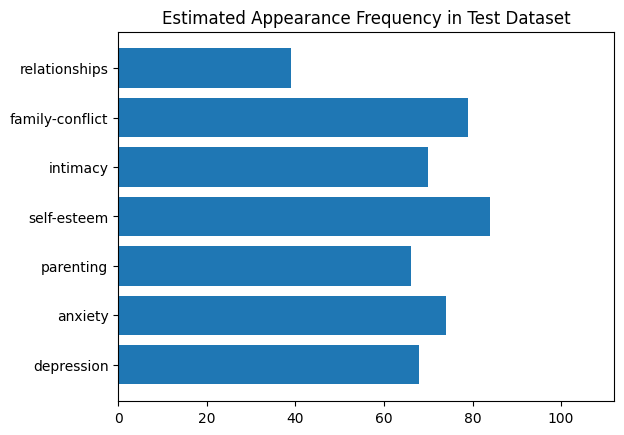

In [12]:
topic_freq = {t: np.sum(p) for t, p in preds.items()}
plt.barh(topics, topic_freq.values())
plt.xlim([0, test_df.shape[0]])
plt.title("Estimated Appearance Frequency in Test Dataset")